In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, TensorDataset
from torchvision.datasets import ImageFolder
import os
from sklearn.utils import resample
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from torchvision.transforms.functional import rotate  # rotate 함수 임포트
from torchvision import datasets, transforms  # datasets 모듈 import 추가

In [2]:
#하이퍼 파라미터
num_classes = 4  
num_epoch = 128
batch_size = 64
learning_rate = 0.001

# MPS 사용 설정 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f'Using device: {device}')


Using device: cuda


In [3]:
# 새로운 데이터 전처리: Grayscale만 적용
transform_base = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

# 테스트 및 검증 데이터 전처리: Grayscale만 적용
transform_test = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

In [4]:
# 데이터셋 로드
data_dir = './emotion_data'

# 학습, 검증, 테스트 데이터셋 로드
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform_base)
val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform_test)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=transform_test)


In [5]:
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [6]:
# Grayscale에 맞는 ResNet18 기본 모델 정의
class GrayscaleResNet18(nn.Module):
    def __init__(self, num_classes=4):
        super(GrayscaleResNet18, self).__init__()
        self.model = models.resnet18(pretrained=True)
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)  # Grayscale용 수정
        self.model.fc = nn.Linear(512, num_classes)  # 클래스 수 수정

    def forward(self, x):
        return self.model(x)

In [7]:
import torch
import torch.nn as nn
import torchvision.models as models

class ModifiedResNet18_LastBlock(nn.Module):
    def __init__(self, original_model):
        super(ModifiedResNet18_LastBlock, self).__init__()
        
        # 기존 ResNet18의 초기 레이어 및 대부분의 블록을 포함
        self.features = nn.Sequential(
            *list(original_model.children())[:-2]  # 마지막 Fully Connected Layer를 제외
        )

        # 새로운 Residual Block 추가
        self.new_block = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
        )

        # 마지막 Fully Connected Layer
        self.fc = nn.Linear(512, 4)  # num_classes = 4으로 변경

    def forward(self, x):
        x = self.features(x)  # 초기 ResNet 레이어 통과
        identity = x  # 스킵 연결용 원본 입력 저장

        out = self.new_block(x)  # 추가된 블록 통과
        out += identity  # 스킵 연결: 입력 x를 출력에 더함
        out = nn.ReLU(inplace=True)(out)  # 활성화 함수 적용

        out = nn.AdaptiveAvgPool2d(1)(out)  # 글로벌 평균 풀링
        out = out.view(out.size(0), -1)  # 플래튼
        out = self.fc(out)  # 최종 FC 레이어
        return out


In [8]:
class ModifiedResNet18_FirstBlock(nn.Module):
    def __init__(self, original_model):
        super(ModifiedResNet18_FirstBlock, self).__init__()
        
        # 기존 ResNet18의 초기 레이어 및 첫 번째 블록을 포함
        self.initial = nn.Sequential(
            *list(original_model.children())[:4]  # Conv1 + BatchNorm1 + ReLU + MaxPool
        )

        # 새로운 Residual Block 추가
        self.new_block = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
        )

        # 기존 ResNet18의 나머지 부분
        self.remaining = nn.Sequential(
            *list(original_model.children())[4:-2]
        )

        # 마지막 Fully Connected Layer
        self.fc = nn.Linear(512, 4)  # num_classes = 4으로 변경

    def forward(self, x):
        x = self.initial(x)  # 초기 레이어 통과
        identity = x  # 스킵 연결용 원본 입력 저장

        out = self.new_block(x)  # 추가된 블록 통과
        out += identity  # 스킵 연결: 입력 x를 출력에 더함
        out = nn.ReLU(inplace=True)(out)  # 활성화 함수 적용

        out = self.remaining(out)  # ResNet의 나머지 레이어 통과
        out = nn.AdaptiveAvgPool2d(1)(out)  # 글로벌 평균 풀링
        out = out.view(out.size(0), -1)  # 플래튼
        out = self.fc(out)  # 최종 FC 레이어
        return out



In [9]:
class ModifiedResNet18_MiddleBlock(nn.Module):
    def __init__(self, original_model):
        super(ModifiedResNet18_MiddleBlock, self).__init__()
        
        # 기존 ResNet18의 초기 레이어 및 첫 번째 두 블록을 포함
        self.initial = nn.Sequential(
            *list(original_model.children())[:6]  # Conv1 + BatchNorm1 + ReLU + MaxPool + Layer1 + Layer2
        )

        # 새로운 Residual Block 추가
        self.new_block = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
        )

        # 기존 ResNet18의 나머지 부분
        self.remaining = nn.Sequential(
            *list(original_model.children())[6:-2]
        )

        # 마지막 Fully Connected Layer
        self.fc = nn.Linear(512, 4)  # num_classes = 4으로 변경

    def forward(self, x):
        x = self.initial(x)  # 초기 레이어 통과
        identity = x  # 스킵 연결용 원본 입력 저장

        out = self.new_block(x)  # 추가된 블록 통과
        out += identity  # 스킵 연결: 입력 x를 출력에 더함
        out = nn.ReLU(inplace=True)(out)  # 활성화 함수 적용

        out = self.remaining(out)  # ResNet의 나머지 레이어 통과
        out = nn.AdaptiveAvgPool2d(1)(out)  # 글로벌 평균 풀링
        out = out.view(out.size(0), -1)  # 플래튼
        out = self.fc(out)  # 최종 FC 레이어
        return out


In [10]:
# 네 가지 모델 정의
original_model = GrayscaleResNet18()
models_dict = {
    "original_model": original_model,
    "modified_last_block": ModifiedResNet18_LastBlock(original_model.model),
    "modified_first_block": ModifiedResNet18_FirstBlock(original_model.model),
    "modified_middle_block": ModifiedResNet18_MiddleBlock(original_model.model),
}

c:\Users\DS\anaconda3\envs\EIC_LAB\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\DS\anaconda3\envs\EIC_LAB\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
# 필요한 경우 일부 레이어는 고정
for model_name, model in models_dict.items():
    for param in model.parameters():
        param.requires_grad = True  # 모든 레이어 학습 가능하도록 설정

    # 모델을 device로 이동
    model = model.to(device)

In [12]:
def train_model_per_epoch(model, train_loader, val_loader, num_epoch, learning_rate, model_name):
    print(f"Training {model_name}...")
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_accuracy = 0.0
    best_model_state = None  # 최고 성능의 모델 상태 저장

    for epoch in range(num_epoch):
        model.train()  # 학습 모드
        running_loss = 0.0
        correct = 0
        total = 0

        # Train 데이터 학습
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accuracy = (correct / total) * 100  # 퍼센트 형식으로 변환

        # Validation 데이터 검증
        model.eval()  # 평가 모드
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_accuracy = (correct / total) * 100  # 퍼센트 형식으로 변환

        # 에폭별 출력 (한 줄로 출력)
        print(f"Epoch [{epoch + 1}/{num_epoch}] - Loss: {running_loss / len(train_loader):.4f}, "
              f"Train Acc: {train_accuracy:.2f}%, Val Acc: {val_accuracy:.2f}%")

        # Validation Accuracy가 최고일 때 모델 상태를 메모리에 저장
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_model_state = model.state_dict()  # 모델 상태를 메모리에 저장

    # 모든 에폭이 끝난 후 가중치 저장
    if best_model_state is not None:
        torch.save(best_model_state, f"{model_name}.pth")
        print(f"\nBest model saved to {model_name}.pth - Best Val Acc: {best_accuracy:.2f}%")

    print(f"\nTraining of {model_name} completed. Best Val Acc: {best_accuracy:.2f}%")


In [13]:
# 테스트 함수 정의
def test_model(model, test_loader, weight_file):
    print(f"Testing with {weight_file}...")
    model.load_state_dict(torch.load(weight_file))
    model.to(device)
    model.eval()

    correct = 0
    total = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    test_accuracy = correct / total
    print(f"Test Accuracy: {test_accuracy:.4f}")

    # 혼동 행렬 출력
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(num_classes)))
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix for {weight_file}")
    plt.show()


In [14]:
# 네 가지 모델 순차적으로 학습 및 저장
for model_name, model in models_dict.items():
    train_model_per_epoch(model, train_loader, val_loader, num_epoch, learning_rate, model_name)

Training original_model...
Epoch [1/128] - Loss: 0.6744, Train Acc: 71.81%, Val Acc: 73.23%
Epoch [2/128] - Loss: 0.5333, Train Acc: 78.42%, Val Acc: 74.65%
Epoch [3/128] - Loss: 0.4723, Train Acc: 80.86%, Val Acc: 79.34%
Epoch [4/128] - Loss: 0.4164, Train Acc: 83.21%, Val Acc: 78.58%
Epoch [5/128] - Loss: 0.3645, Train Acc: 85.50%, Val Acc: 75.14%
Epoch [6/128] - Loss: 0.3077, Train Acc: 88.05%, Val Acc: 78.43%
Epoch [7/128] - Loss: 0.2515, Train Acc: 90.31%, Val Acc: 78.24%
Epoch [8/128] - Loss: 0.1868, Train Acc: 92.92%, Val Acc: 79.08%
Epoch [9/128] - Loss: 0.1388, Train Acc: 94.83%, Val Acc: 79.19%
Epoch [10/128] - Loss: 0.1050, Train Acc: 96.08%, Val Acc: 77.93%
Epoch [11/128] - Loss: 0.0846, Train Acc: 96.96%, Val Acc: 76.63%
Epoch [12/128] - Loss: 0.0692, Train Acc: 97.49%, Val Acc: 78.01%
Epoch [13/128] - Loss: 0.0663, Train Acc: 97.63%, Val Acc: 78.08%
Epoch [14/128] - Loss: 0.0519, Train Acc: 98.12%, Val Acc: 78.01%
Epoch [15/128] - Loss: 0.0579, Train Acc: 97.99%, Val Acc:

Testing with original_model.pth...
Test Accuracy: 0.8225


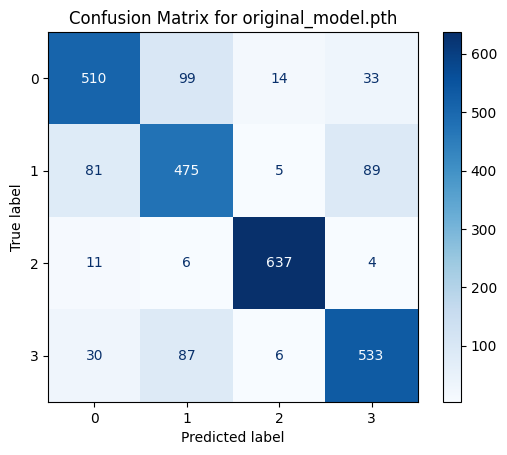

Testing with modified_last_block.pth...
Test Accuracy: 0.8218


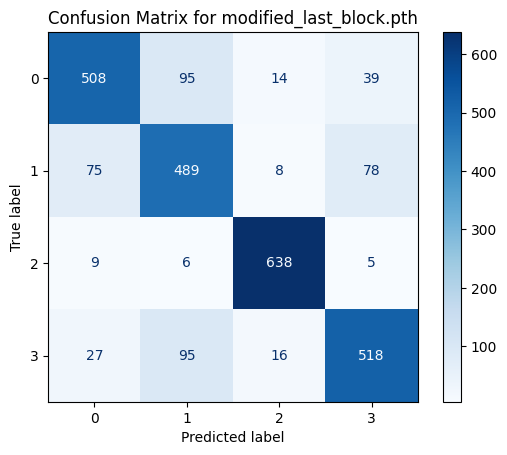

Testing with modified_first_block.pth...
Test Accuracy: 0.8103


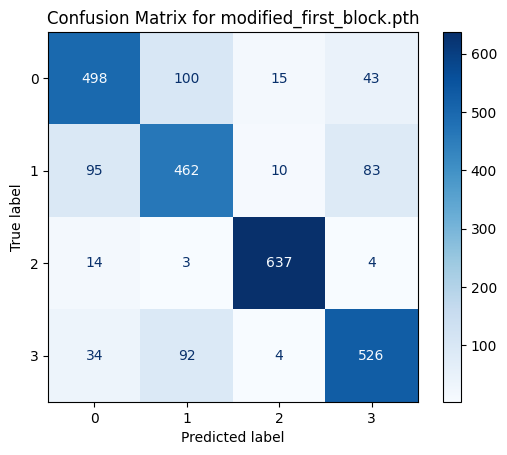

Testing with modified_middle_block.pth...
Test Accuracy: 0.8233


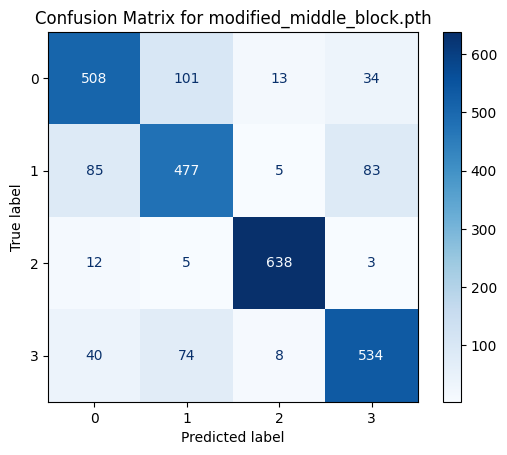

In [15]:
# 테스트 단계: 저장된 가중치로 평가
for model_name in models_dict.keys():
    test_model(models_dict[model_name], test_loader, f"{model_name}.pth")